# Introduction to Flux Balance Analysis

Author: Daniel Machado, NTNU

License: [CC BY-SA 4.0](http://creativecommons.org/licenses/by-sa/4.0/)

-------

In this tutorial:

- You will learn how to perform flux balance analysis 
using a model of the [central carbon metabolism of *E. coli*](https://journals.asm.org/doi/10.1128/ecosalplus.10.2.1). This is a very simple model, mostly used for educational purposes.

- You will use the [ReFramed](https://github.com/cdanielmachado/reframed) python library for metabolic modeling. You can check the [online documentation](https://reframed.readthedocs.io) for more details.

- You will execute pre-defined pieces of code, but you are strongly encouraged to modify the code and explore on your own.

## Step 1: Loading a model

We begin by loading the model, which is stored in SBML format:

In [1]:
from reframed import load_cbmodel
model = load_cbmodel('../files/e_coli_core.xml')

Let's learn some details about the model:

In [2]:
model.summary()

Metabolites:
e 20
c 52

Reactions:
enzymatic 48
transport 25
exchange 20
sink 0
other 2


## Step 2: Running an FBA simulation

The most simple thing you can do with a constraint-based model is to run a flux balance analysis (FBA) simulation.

> **Note:** unless you explicitely make some changes, the simulation will use the default objective function (biomass maximization) and environmental conditions (aerobic growth in M9 minimal medium with glucose) that came pre-defined in this model.

In [3]:
from reframed import FBA
solution = FBA(model)

The solution object contains the objective value (the growth rate in this case), and the respective flux distribution. 

In [4]:
print(solution)

Objective: 0.8739215069684303
Status: Optimal



You can inspect all the fluxes, or select some you are interested in. Let's look at the uptake and secretion rates (which are combined in the form of *exchange* reactions).

In [5]:
solution.show_values(pattern="R_EX", sort=True)

R_EX_o2_e    -21.7995
R_EX_glc__D_e -10
R_EX_nh4_e   -4.76532
R_EX_pi_e    -3.2149
R_EX_h_e      17.5309
R_EX_co2_e    22.8098
R_EX_h2o_e    29.1758


We can see that *E. coli* is consuming glucose and oxygen and producing CO2.

## Step 3: Visualizing fluxes with Escher

Escher is a really nice tool for displaying fluxes in a metabolic map. It makes your life easier, especially when comparing flux distributions after performing some perturbations (such as gene deletions or changes in the growth medium).

In [6]:
from reframed import fluxes2escher
fluxes2escher(solution.values)

Builder(reaction_data={'ACALD': 0.0, 'ACALDt': 0.0, 'ACKr': 0.0, 'ACONTa': 6.007249575350336, 'ACONTb': 6.0072…

## Step 4: Changing the environmental conditions

You can change growth conditions either by modifying the flux bounds of the reactions directly in the model or by supplying those constraints as an argument to the FBA simulation method.

Let's observe what happens if we remove oxygen uptake to simulate anaerobic growth:

In [7]:
solution2 = FBA(model, constraints={'R_EX_o2_e':0})

In [8]:
print(solution2)

Objective: 0.2116629497353106
Status: Optimal



In [9]:
solution2.show_values(pattern="R_EX", sort=True)

R_EX_glc__D_e -10
R_EX_h2o_e   -7.1158
R_EX_nh4_e   -1.15416
R_EX_pi_e    -0.778644
R_EX_co2_e   -0.378178
R_EX_etoh_e   8.27946
R_EX_ac_e     8.50359
R_EX_for_e    17.8047
R_EX_h_e      30.5542


As expected, *E. coli* switched to a fermentation mode, which resulted in the secretion of fermentation products and a decrease in growth rate.

Again, we can see it better by displaying the flux distribution in a metabolic map.

In [10]:
fluxes2escher(solution2.values)

Builder(reaction_data={'ACALD': -8.279455380486581, 'ACALDt': 0.0, 'ACKr': -8.503585277961301, 'ACONTa': 0.228…

## Step 5: Comparing simulations with experimental data

Ok, so hopefully you are now convinced that metabolic models and FBA simulations are easy and fun to play with. But can we really trust these flux predictions? 

There is only one way to know. Let's compare them with experimentally measured fluxes. 

[Gerosa and co-workers](https://www.sciencedirect.com/science/article/pii/S2405471215001465) have measured fluxes in *E. coli* growing with different carbon sources. 

![Flux data](../files/gerosa2015.png)



Let's load the fluxomics data that has been stored as a CSV file...

In [19]:
import pandas as pd
fluxomics = pd.read_csv('../files/gerosa2015.csv', index_col=0)

fluxomics.sample(5) # print 5 random entries

,Acetate,Fructose,Galactose,Glucose,Glycerol,Gluconate,Pyruvate,Succinate
R_GND,2.586719,6.171283,0.418682,2.832284,3.411510,1.464963,0.876802,4.907821
R_EX_succ_e,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.902000
R_CS,8.834019,4.568329,1.520963,2.977971,2.464836,1.154034,8.081921,3.155401
R_SUCOAS,-4.267163,-3.874895,-0.236073,-2.138073,-1.840459,-0.182358,-7.415655,-2.351983
R_EX_glc__D_e,0.000000,0.000000,0.000000,-9.654000,0.000000,0.000000,0.000000,0.000000


We will constrain the model using only the respective uptake rate for each substrate and see how well it predicts the growth rate and all the other fluxes.

Unfortunately, our model only contains 5 of the 8 substrates used in the paper.

In [20]:
uptake_reactions = {
    'Acetate': 'R_EX_ac_e',
    'Fructose': 'R_EX_fru_e',
    'Glucose': 'R_EX_glc__D_e',
    'Pyruvate': 'R_EX_pyr_e',
    'Succinate': 'R_EX_succ_e',
}

growth_rates = {
    'Acetate': 0.29,
    'Fructose': 0.49,
    'Glucose': 0.65,
    'Pyruvate': 0.39,
    'Succinate': 0.51,
}

We need to remove glucose from the pre-defined medium, by setting the lower bound of the exchange reaction to zero: 

In [12]:
model.reactions.R_EX_glc__D_e.lb = 0

Now let's run simulations for all the five conditions. 

> The code below might look a bit complicated. Don't worry about that for now.

In [21]:
simulated = {}
print('Condition \tGrowth \tPredicted')

for condition, rxn_id in uptake_reactions.items():
    uptake_rate = fluxomics.loc[rxn_id, condition]
    solution = FBA(model, constraints={rxn_id: uptake_rate})
    simulated[f'{condition}_sim'] = solution.values
    print(f'{condition} \t{growth_rates[condition]} \t{solution.fobj:.2f}')
    
combined = pd.concat([fluxomics, pd.DataFrame(simulated)], axis=1, join='inner')

Condition 	Growth 	Predicted
Acetate 	0.29 	0.25
Fructose 	0.49 	0.72
Glucose 	0.65 	0.84
Pyruvate 	0.39 	0.84
Succinate 	0.51 	0.66


It seems that, in general, the model predicted higher growth rates than what was measured. 

> Why do you think this has happened?

One of the limitations of FBA is that it does not predict overflow metabolism, unless we explicitly add additional constraints.

So let's now additionally constrain the acetate secretion rate as well and see if our predictions improve.

In [26]:
simulated = {}
print('Condition \tGrowth \tPredicted')

for condition, rxn_id in uptake_reactions.items():
    constraints = {
        rxn_id: fluxomics.loc[rxn_id, condition],
        'R_EX_ac_e': fluxomics.loc['R_EX_ac_e', condition],
    }
    solution = FBA(model, constraints=constraints)
    simulated[f'{condition}_sim'] = solution.values
    print(f'{condition} \t{growth_rates[condition]} \t{solution.fobj:.2f}')
    
combined2 = pd.concat([fluxomics, pd.DataFrame(simulated)], axis=1, join='inner')

Condition 	Growth 	Predicted
Acetate 	0.29 	0.25
Fructose 	0.49 	0.64
Glucose 	0.65 	0.69
Pyruvate 	0.39 	0.58
Succinate 	0.51 	0.58


There is some improvement in the prediction of growth rates. But what about the fluxes? 
How well are they predicted, and does this also improve when we constrain acetate secretion?

The code below plots measured vs predicted fluxes, before and after constraining acetate secretion.

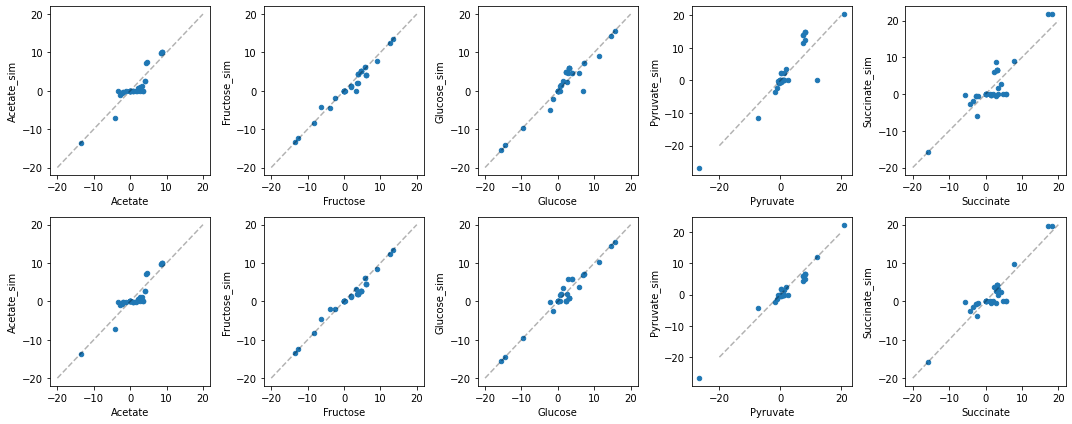

In [25]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i, condition in enumerate(uptake_reactions):
    combined.plot.scatter(condition, f'{condition}_sim', ax=axs[0,i])
    axs[0,i].plot([-20, 20], [-20, 20], 'k--', alpha=0.3)
    
    combined2.plot.scatter(condition, f'{condition}_sim', ax=axs[1,i])
    axs[1,i].plot([-20, 20], [-20, 20], 'k--', alpha=0.3)

fig.tight_layout()

You have reached the end of this tutorial. Feel free to go back and try different things.